수정일: 2025.10.11

# HW3: MNIST classification

이번 과제에서는 neural network와 MNIST 데이터셋을 이용해 숫자 이미지를 분류해 보겠다. 또한, validation set을 이용하는 방법과 test set을 이용해 평가하는 방법도 학습해 보겠다. 그리고, 학습에는 Mini-Batch Gradient Descent 방법을 이용한다.

**이번 과제에서는 GPU를 이용한다. 이를 위해서는 메뉴의 [런타임]-[런타임 유형 변경]에서 '하드웨어 가속기'를 'T4 GPU'로 선택해야 한다.**

우선 필요한 모듈을 불러오고, 필요한 셋팅을 한다.

In [1]:
import numpy as np # NumPy
import matplotlib.pyplot as plt # Matplotlib

import torch # PyTorch
import torchvision # MNIST 데이터셋을 읽기 위해 필요
import torchvision.transforms as transforms # MNIST 데이터셋을 읽기 위해 필요
from torch import nn # PyTorch 레이어

## MNIST 데이터셋

MNIST(Modified National Institute of Standards and Technology) 데이터셋은 손으로 쓴 0부터 9까지의 숫자를 이미지로 만든 데이터셋이다. MNIST는 60,000개의 training set과 10,000개의 test set으로 이루어져 있다. 또한, 각각의 데이터는 28x28 픽셀로 구성된 흑백 이미지이다.

아래 코드는 인터넷에서 MNIST 데이터셋을 다운로드 받아 저장한다. 이는 [torchvision.datasets.MNIST](https://pytorch.org/vision/stable/datasets.html#mnist)를 이용하면 쉽게 할 수 있다.

Validation을 위해 training set 중 10,000개를 validation set으로 사용하고, 50,000개만 training set으로 사용한다. 데이터셋을 분리하는 것은 [torch.utils.data.dataset.random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split)을 이용한다.

In [2]:
transform = transforms.Compose([transforms.ToTensor()]) # 불러온 이미지를 tensor로 변환해준다.

dataset = torchvision.datasets.MNIST('dataset', train=True, download=True, transform=transform) # training set을 다운로드 한다.
testset = torchvision.datasets.MNIST('dataset', train=False, download=True, transform=transform) # test set을 다운로드 한다.

trainset, validationset = torch.utils.data.dataset.random_split(dataset, [50000, 10000]) # training set을 다시 50000개와 10000개로 분할한다.

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 472kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.0MB/s]


MNIST 데이터셋의 기본 정보를 출력한다. 이 때, 이미지의 크기가 28x28인 것을 확인하고, 각 픽셀의 값이 0에서 1 사이의 값을 갖는 것을 확인한다. 그리고, 레이블 정보는 0~9 사이의 정수로 저장되어 있다.

In [3]:
print("Traning set 개수:", len(trainset))
print("Validation set 개수:", len(validationset))
print("Test set 개수:", len(testset))

# training set의 데이터를 가져온다. 이 때, x에는 입력 데이터(즉, 숫자 이미지)가, y에는 입력 데이터에 대한 출력 데이터(즉, 레이블)이 저장된다.
for x, y in trainset:
  print("Shape of x:", x.shape) # [1, 28, 28]
  print("x:", x) # 각 픽셀이 0~1 사이의 값을 갖는 것을 확인
  print("Label:", y) # 0~9 사이의 값
  break # 한 개에 대해서만 출력하고 종료

Traning set 개수: 50000
Validation set 개수: 10000
Test set 개수: 10000
Shape of x: torch.Size([1, 28, 28])
x: tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 

MNIST 데이터셋의 일부 이미지를 출력해본다.

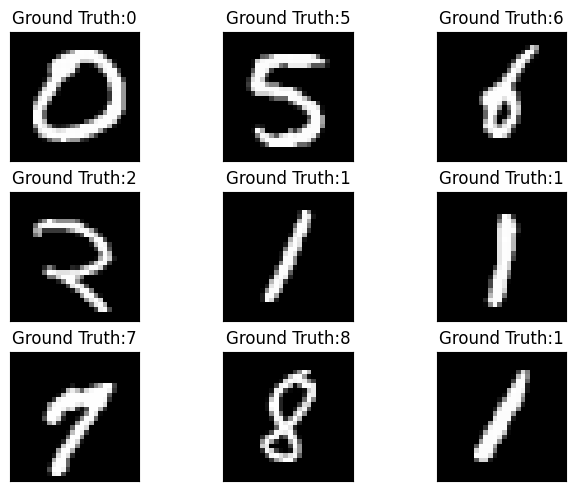

In [4]:
_, axes = plt.subplots(3, 3, layout='constrained') # 3행 3열의 격자로 이미지를 표시한다.

for i, (x, y) in enumerate(trainset):

  ax = axes[i//3, i%3]

  #plt.tight_layout()
  ax.imshow(x.reshape((28, 28)), cmap='gray', interpolation='none') # 이미지를 표시한다.
  ax.set_title(f"Ground Truth:{y}")
  ax.set_xticks([])
  ax.set_yticks([])

  if i >= 8: # 9개의 이미지만 보여준다.
    break

plt.show()

## 모델 정의

MNIST 데이터셋을 분류하기 위한 neural network 모델을 정의한다.

Neural network 모델을 정의하기 위해 [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)에서 상속받은 클래스를 정의한다. 그리고 *\_\_init\_\_()* 함수 안에 네트워크의 레이어들을 정의하고, *forward()* 함수 안에서 정의한 레이어들을 연결해 준다.

각 레이어는 [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)와 [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)를 이용해 정의한다. 그리고 마지막 출력층에는 ReLU 함수 대신 softmax 함수를 사용하는데, 이는 [nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)로 정의한다. 그러나, 여기서는 마지막에 직접 softmax를 추가하지 않는다. 이는 뒤에 나오는 [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)가 대신 해줄 것이다.

MNIST 데이터셋의 이미지는 28x28(=784) 크기를 가지는 2차원 배열이다. 그러나, neural network 특성상, 2차원 데이터를 입력으로 받지 못한다. 따라서, 28x28 크기의 이차원 데이터를 784개의 1차원 데이터로 변환해서 사용해야 한다. 이러한 과정을 flattening이라고 한다.

<img src="https://miro.medium.com/max/425/1*GLQjM9k0gZ14nYF0XmkRWQ.png"/>

따라서, neural network는 총 784개의 입력 노드가 필요하다. 또한, 0에서 9까지 10개의 레이블을 사용하므로, 10개의 출력 노드가 필요하다.

이번에는 [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)을 이용해 레이어들을 연결해본다. 또한, 이번 과제에서는 좋은 성능을 가지도록 **여러분이 직접 레이어를 정의**한다.

**지시: 좋은 성능을 낼 수 있게 다음 neural network 모델을 정의한다.**

In [5]:
class MnistModel(nn.Module): # nn.Module을 상속받은 클래스를 정의. 이름을 MnistModel로 정의하였다.
  def __init__(self): # 이 안에 레이어들을 정의한다.
    super(MnistModel, self).__init__()

    self.flatten = nn.Flatten() # 28x28의 2차원 배열을 784개의 1차원 배열로 펼쳐준다.

    ## 아래 코드를 적절히 수정하시오.
    #### 코드 시작 ####
    self.layers = nn.Sequential(
      nn.Linear(784, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 10)
      # 마지막에 softmax를 추가하지 않는다.
      )
    #### 코드 종료 ####

  def forward(self, x): # 이 안에 레이어들을 연결해준다.
    x = self.flatten(x) # 2차원 배열을 일차원 배열로 변환
    x = self.layers(x)
    return x

위에서 정의한 MnistModel를 생성해 model 변수에 저장한다. 아무 문제가 없다면 아래 코드 실행 시 "성공!!!"이라고 출력되어야 한다.

In [6]:
model = MnistModel().cuda() # GPU에 모델 생성

random_data = torch.rand((1, 784)).cuda()
result = model(random_data)

assert result.shape == (1, 10)
print("성공!!!")

성공!!!


기본적으로 PyTorch에서는 가중치를 적절히 초기화 해주지만, 직접 가중치를 초기화 할 수도 있다. 초기화에 필요한 함수들은 [torch.nn.init](https://pytorch.org/docs/stable/nn.init.html) 모듈에 정의되어 있다.

이번 과제에서는 가중치에는 He initialization을 사용한다. 그리고 Bias는 0으로 초기화한다.

In [7]:
def init_weights(m):
  if isinstance(m, nn.Linear):
    nn.init.kaiming_normal_(m.weight.data) # He initialization
    m.bias.data.zero_() # Bias는 0으로 초기화

model.apply(init_weights)

MnistModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)

## 학습

학습을 위해 하이퍼파라미터를 설정한다. 이번 과제에서는 여러분이 직접 하이퍼파라미터를 설정한다.

**지시: 좋은 성능을 낼 수 있게 아래 hyperparameter를 조정한다.**

In [8]:
# Hyperparameter를 설정한다.
# 사용자가 변경할 수 있다.
epochs = 50 # 최대 epoch
learning_rate = 0.01 # Learning rate
batch_size = 64 # Batch size

이번부터는 mini-batch gradient descent 최적화 방법을 사용할 것이다. 따라서, 데이터를 batch size 개수만큼 학습시켜야 한다. 이를 위해, 데이터를 batch size 단위로 나누어 불러올 수 있게 [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)를 사용한다. DataLoader를 사용하면 batch size 개수만큼 데이터를 나누어 불러올 수 있다. Training set과 validation set 모두에 대해 각각의 DataLoader를 만들어준다.

In [9]:
# shuffle=True는 데이터를 불러올 때, 데이터를 섞어준다.
trainset_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
validationset_loader = torch.utils.data.DataLoader(dataset=validationset, batch_size=batch_size, shuffle=True)

Optimizer를 정의한다. 여기서는 Stochastic Gradient Descent(SGD)를 이용해 batch size 단위로 최적화를 한다.

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Loss function을 정의한다. 여기서는 PyTorch가 제공하는 [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)를 사용한다. 이는 자체적으로 softmax 함수를 포함하므로, 모델에 softmax 활성화 함수를 별도로 추가할 필요가 없다. 또한, y를 one-hot encoding으로 변환하지 않아도 내부적으로 변환해 처리해 준다.

In [11]:
loss_function = nn.CrossEntropyLoss()

한 번의 epoch에 대해 데이터를 batch size 단위로 모델을 학습시키는 함수를 만든다. 이 함수는 dataloader에서 batch size 만큼 데이터를 가져와 optimizer를 이용해 학습한다.

In [12]:
def train_loop(dataloader, model, loss_func, optimizer):
  size = len(dataloader.dataset) # 데이터 개수
  training_loss = 0 # Loss를 저장하기 위한 변수
  correct = 0 # 정답을 맞춘한 개수를 저장

  for X, y in dataloader: # dataloader를 이용해 batch size 만큼 입력 데이터 X와 출력 데이터 y를 가져온다.
    X = X.cuda() # X를 GPU로 이동
    y = y.cuda() # y를 GPU로 이동

    optimizer.zero_grad() # Gradient를 0으로 초기화
    output = model(X) # 모델을 이용해 forward propagation 수행
    loss = loss_func(output, y) # loss 계산. y를 one-hot encoding으로 변환하지 않아도 된다.
    loss.backward() # Backpropagation 수행
    optimizer.step() # 가중치 업데이트

    training_loss += loss.item() * output.shape[0] # Loss를 누적시킨다. 이 때, loss는 batch size에 대한 평균이므로 다시 곱해준다.

    prediction = output.argmax(1) # 예측한 결과
    correct += (prediction == y).type(torch.float).sum().item() # 예측한 결과와 출력 데이터(정답)을 비교해 맞은 개수를 찾는다.

  training_loss /= size # 평균 loss를 계산
  accuracy = correct / size # 정확도를 계산

  return training_loss, accuracy

한 번의 epoch에 대해 데이터를 batch size 단위로 모델을 평가하는 함수를 만든다. 이 함수는 dataloader에서 batch size 만큼 데이터를 가져와 학습된 모델을 이용해 loss 및 정확도를 계산한다.

In [13]:
def test_loop(dataloader, model, loss_func):
  size = len(dataloader.dataset) # 데이터 개수
  test_loss = 0 # Loss를 저장하기 위한 변수
  correct = 0 # 정답을 맞춘 개수를 저장

  with torch.no_grad(): # 미분을 수행하지 않음
    for X, y in dataloader: # dataloader를 이용해 batch size 만큼 입력 데이터 X와 출력 데이터 y를 가져온다.
      X = X.cuda() # X를 GPU로 이동
      y = y.cuda() # y를 GPU로 이동

      output = model(X) # 모델을 이용해 forward propagation 수행하여 결과 예측
      loss = loss_func(output, y)
      test_loss += loss.item() * output.shape[0] # loss 계산. y를 one-hot encoding으로 변환하지 않아도 된다.

      prediction = output.argmax(1) # 예측한 결과
      correct += (prediction == y).type(torch.float).sum().item() # 예측한 결과와 출력 데이터(정답)을 비교해 맞은 개수를 찾는다.

    test_loss /= size # 평균 loss를 계산
    accuracy = correct / size # 정확도를 계산

  return test_loss, accuracy

Training set을 이용해 모델을 학습하고, validation set을 이용해 검증하는 루프를 구현한다. 그리고, 매 epoch 마다 loss 및 accuracy를 저장한다.

In [14]:
# 학습 상황을 저장하기 위한 변수
train_loss_history = []
train_accuracy_history = []
validation_loss_history = []
validation_accuracy_history = []

for epoch in range(1, epochs+1): # 최대 epoch만큼 반복한다.
  print("Epoch:", epoch)

  train_loss, train_accuracy = train_loop(trainset_loader, model, loss_function, optimizer) # train set을 이용해 학습한다.
  train_loss_history.append(train_loss) # train set에 대한 loss를 저장한다.
  train_accuracy_history.append(train_accuracy) # train set에 대한 accuracy를 저장한다.

  validation_loss, validation_accuracy = test_loop(validationset_loader, model, loss_function) # validation set을 이용해 검증한다.
  validation_loss_history.append(validation_loss) # validation set에 대한 loss를 저장한다.
  validation_accuracy_history.append(validation_accuracy) # validation set에 대한 accuracy를 저장한다.

  print("Training accuracy:", train_accuracy, "Training loss:", train_loss)
  print("Validation accuracy:", validation_accuracy, "Validation loss:", validation_loss)

Epoch: 1
Training accuracy: 0.77966 Training loss: 0.7966277895402908
Validation accuracy: 0.8901 Validation loss: 0.3903683867454529
Epoch: 2
Training accuracy: 0.90828 Training loss: 0.32153590765953066
Validation accuracy: 0.9126 Validation loss: 0.30422881665229795
Epoch: 3
Training accuracy: 0.92442 Training loss: 0.26239489667415616
Validation accuracy: 0.9224 Validation loss: 0.264412135887146
Epoch: 4
Training accuracy: 0.93426 Training loss: 0.22771965237140657
Validation accuracy: 0.9291 Validation loss: 0.23966491625308992
Epoch: 5
Training accuracy: 0.94162 Training loss: 0.20344608913183213
Validation accuracy: 0.9347 Validation loss: 0.21923969050049782
Epoch: 6
Training accuracy: 0.94682 Training loss: 0.1841691188287735
Validation accuracy: 0.9367 Validation loss: 0.209980659365654
Epoch: 7
Training accuracy: 0.9516 Training loss: 0.16836268998146056
Validation accuracy: 0.9396 Validation loss: 0.1995618143081665
Epoch: 8
Training accuracy: 0.95556 Training loss: 0.1550

매 epoch 마다 loss와 accuracy가 변하는 과정을 그래프로 보여준다. Epoch이 진행됨에 따라서 loss는 감소하고 accuracy는 증가한다. 그리고 validation loss는 training loss보다 일반적으로 크다.

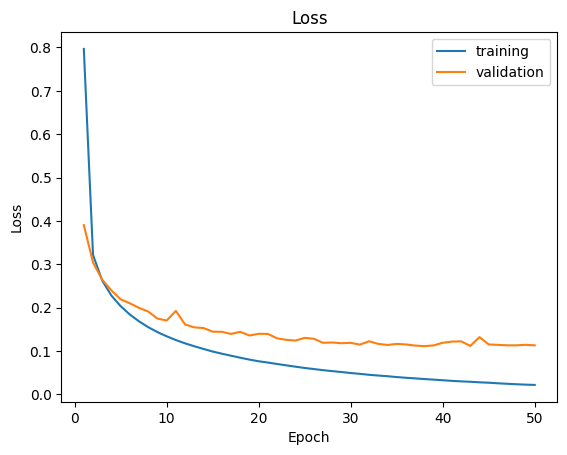

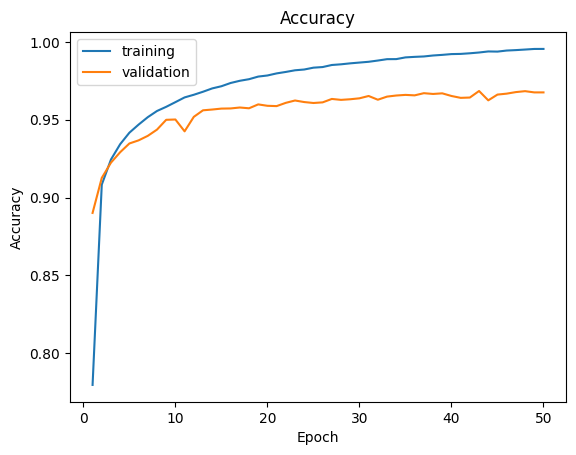

In [15]:
x = np.arange(1, len(train_loss_history)+1, dtype=int)

_, ax = plt.subplots()

# Loss 그래프
ax.plot(x, train_loss_history, label="training")
ax.plot(x, validation_loss_history, label="validation")
ax.set_title('Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

_, ax = plt.subplots()

# Accuracy 그래프
ax.plot(x, train_accuracy_history, label="training")
ax.plot(x, validation_accuracy_history, label="validation")
ax.set_title('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

plt.show()

## 평가
평가에는 test set을 이용한다. 이를 batch size 단위로 불러오기 위해 dataloader를 만든다. 그러나 학습이 아니기 때문에 batch size 단위로 평가할 필요는 없다. 단지, 한 번에 메모리로 불러오는 부담을 줄이기 위해서이다.

**지시: Test accuracy가 96%가 넘도록 모델 및 하이퍼파라미터를 설정한다.**

In [16]:
testset_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size)
_, test_accuracy = test_loop(testset_loader, model, loss_function) # test set을 이용해 평가한다.

print(f"Test accuracy: {test_accuracy}")

if test_accuracy > 0.96:
  print("성공!")
else:
  print("실패! 하이퍼파라미터를 조정하세요.")

Test accuracy: 0.9731
성공!


이번 과제는 여기까지 입니다. 수고하셨습니다.